1. Carga y Exploración de los Datos

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Cargar datasets
electrical = pd.read_csv('data/electrical_data.csv', parse_dates=['measured_on'])
environment = pd.read_csv('data/environment_data.csv', parse_dates=['measured_on'])
irradiance = pd.read_csv('data/irradiance_data.csv', parse_dates=['measured_on'])

# Exploración inicial
print(electrical.info())
print(electrical.describe())
print(electrical.isnull().sum())
print(electrical.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632952 entries, 0 to 632951
Columns: 120 entries, measured_on to inv_24_ac_power_inv_149698
dtypes: datetime64[ns](1), float64(119)
memory usage: 579.5 MB
None
                         measured_on  inv_01_dc_current_inv_149579  \
count                         632952                 632586.000000   
mean   2020-11-04 00:06:34.443181312                      9.856498   
min              2017-11-01 00:00:00                      0.000000   
25%              2019-05-04 12:28:45                      0.000000   
50%              2020-11-03 23:57:30                      0.000000   
75%              2022-05-07 12:26:15                     16.029000   
max              2023-11-07 23:55:00                     52.348000   
std                              NaN                     15.343311   

       inv_01_dc_voltage_inv_149580  inv_01_ac_current_inv_149581  \
count                 632586.000000                 632586.000000   
mean                 

2. Análisis Descriptivo

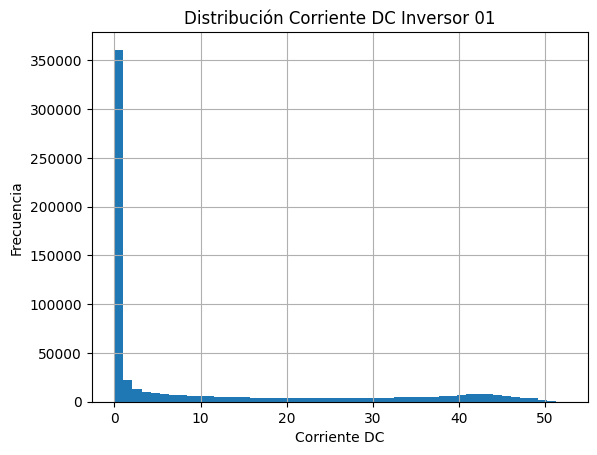

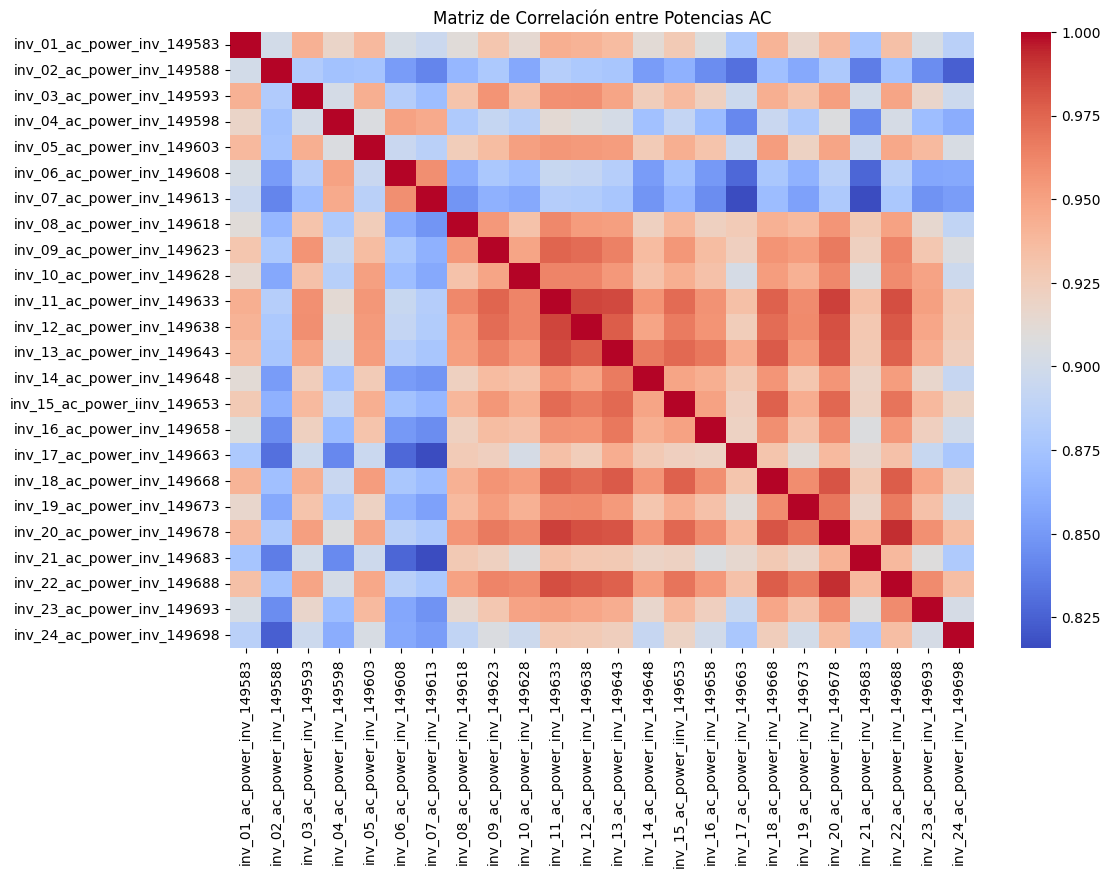

In [64]:
# Histograma de corriente DC del inversor 01
electrical['inv_01_dc_current_inv_149579'].hist(bins=50)
plt.title('Distribución Corriente DC Inversor 01')
plt.xlabel('Corriente DC')
plt.ylabel('Frecuencia')
plt.show()

# Mapa de correlaciones para potencias AC
ac_power_cols = [col for col in electrical.columns if 'ac_power' in col]
plt.figure(figsize=(12, 8))
sns.heatmap(electrical[ac_power_cols].corr(), cmap='coolwarm')
plt.title('Matriz de Correlación entre Potencias AC')
plt.show()


3. Dataset (device y tipo)

In [65]:
df = electrical.copy()

# Derretir todas las columnas (excepto measured_on)
df_melted = df.melt(id_vars='measured_on', var_name='variable', value_name='valor')

# Extraer el número de inversor
df_melted['device'] = df_melted['variable'].str.extract(r'inv_(\d+)').astype(int)

# Extraer el tipo de medición (ac_power, dc_voltage, etc.)
df_melted['type'] = df_melted['variable'].apply(lambda x: x.split('_', 2)[1] + '_' + x.split('_', 2)[2].split('_')[0])


In [66]:
# Extraer tipo de variable: ac_power, dc_voltage, dc_current
def extract_type(varname):
    return '_'.join(varname.split('_')[2:-1])  # quita el prefijo 'inv_XX' y el sufijo '_inv_XXXXX'

df_melted['type'] = df_melted['variable'].apply(extract_type)


In [67]:
df_final = df_melted.pivot_table(index=['measured_on', 'device'], columns='type', values='valor').reset_index()
print(df_final.columns.tolist())


['measured_on', 'device', 'ac_current_inv', 'ac_power_iinv', 'ac_power_inv', 'ac_voltage_inv', 'dc_current_inv', 'dc_voltage_inv']


4. Ingeniería de Características

In [68]:
# Asegúrate de usar los nombres exactos de las columnas existentes
df_final['conversion_efficiency'] = df_final['ac_power_inv'] / (df_final['dc_voltage_inv'] * df_final['dc_current_inv'])

# Estabilidad del voltaje DC
df_final = df_final.sort_values(['device', 'measured_on'])
df_final['dc_voltage_std'] = df_final.groupby('device')['dc_voltage_inv'].rolling(window=3, min_periods=1).std().reset_index(drop=True)

# Impacto ambiental
env = environment[['measured_on', 'ambient_temperature_o_149575']].rename(columns={'ambient_temperature_o_149575': 'ambient_temperature'})
df_final = pd.merge(df_final, env, on='measured_on', how='left')

df_final['env_impact'] = (df_final['ambient_temperature'] - df_final['ambient_temperature'].mean()) * \
                         (df_final['dc_current_inv'] - df_final['dc_current_inv'].mean())


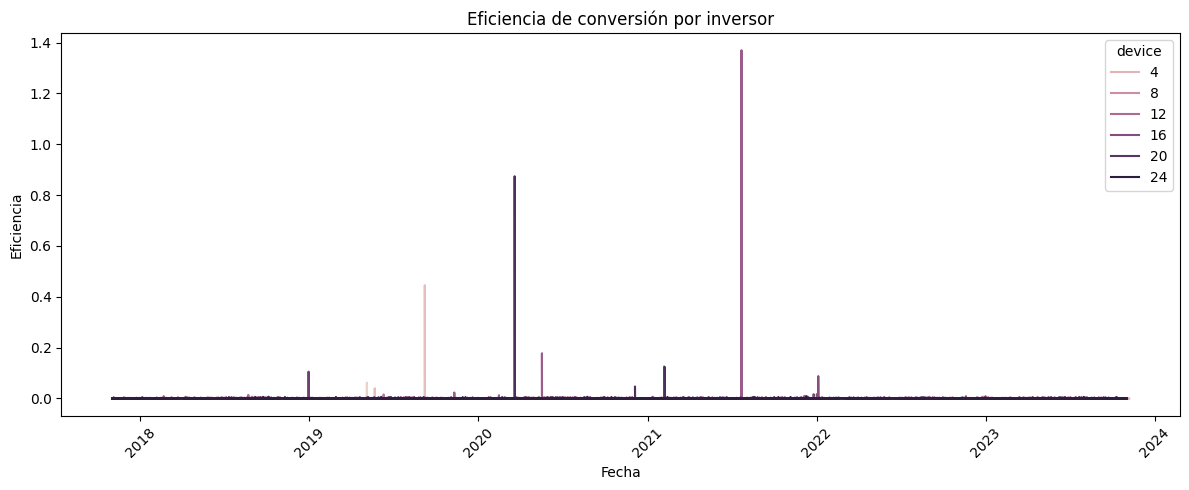

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_final, x='measured_on', y='conversion_efficiency', hue='device')
plt.title('Eficiencia de conversión por inversor')
plt.xlabel('Fecha')
plt.ylabel('Eficiencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\osval\AppData\Local\Temp\ipykernel_13156\1026055499.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\osval\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


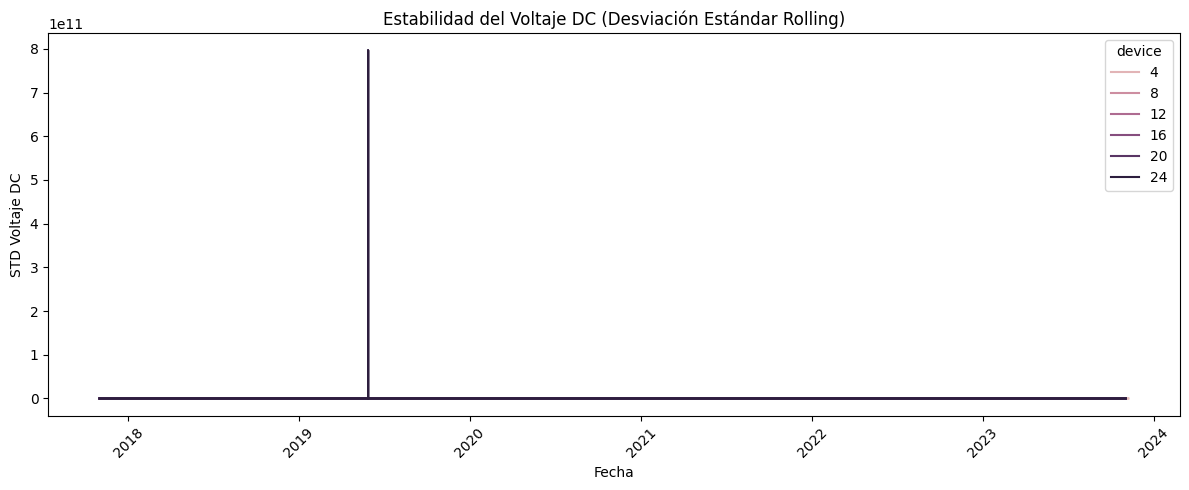

In [70]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_final, x='measured_on', y='dc_voltage_std', hue='device')
plt.title('Estabilidad del Voltaje DC (Desviación Estándar Rolling)')
plt.xlabel('Fecha')
plt.ylabel('STD Voltaje DC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


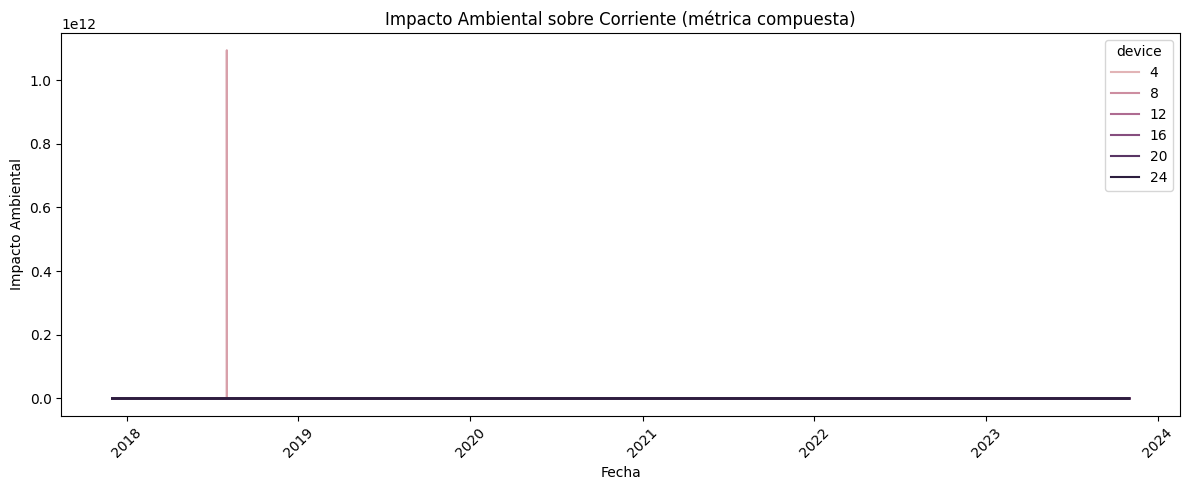

In [71]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_final, x='measured_on', y='env_impact', hue='device')
plt.title('Impacto Ambiental sobre Corriente (métrica compuesta)')
plt.xlabel('Fecha')
plt.ylabel('Impacto Ambiental')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. Cubos OLAP

In [72]:
# Cubo diario de eficiencia
df_final['day'] = df_final['measured_on'].dt.date
cube_eff = pd.pivot_table(df_final, index='device', columns='day', values='conversion_efficiency', aggfunc='mean')

# Cubo por hora de estabilidad e impacto ambiental
df_final['hour'] = df_final['measured_on'].dt.hour
cube_stability = pd.pivot_table(df_final, index='device', columns='hour',
                                values=['dc_voltage_std', 'env_impact'], aggfunc='mean')


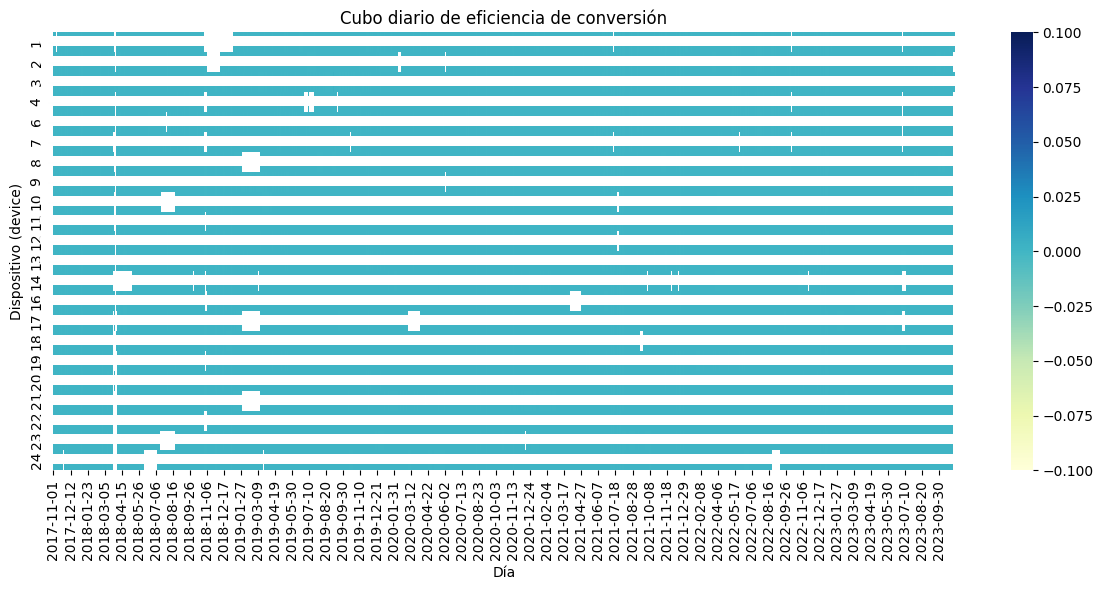

In [73]:
plt.figure(figsize=(12, 6))
sns.heatmap(cube_eff, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Cubo diario de eficiencia de conversión')
plt.xlabel('Día')
plt.ylabel('Dispositivo (device)')
plt.tight_layout()
plt.show()


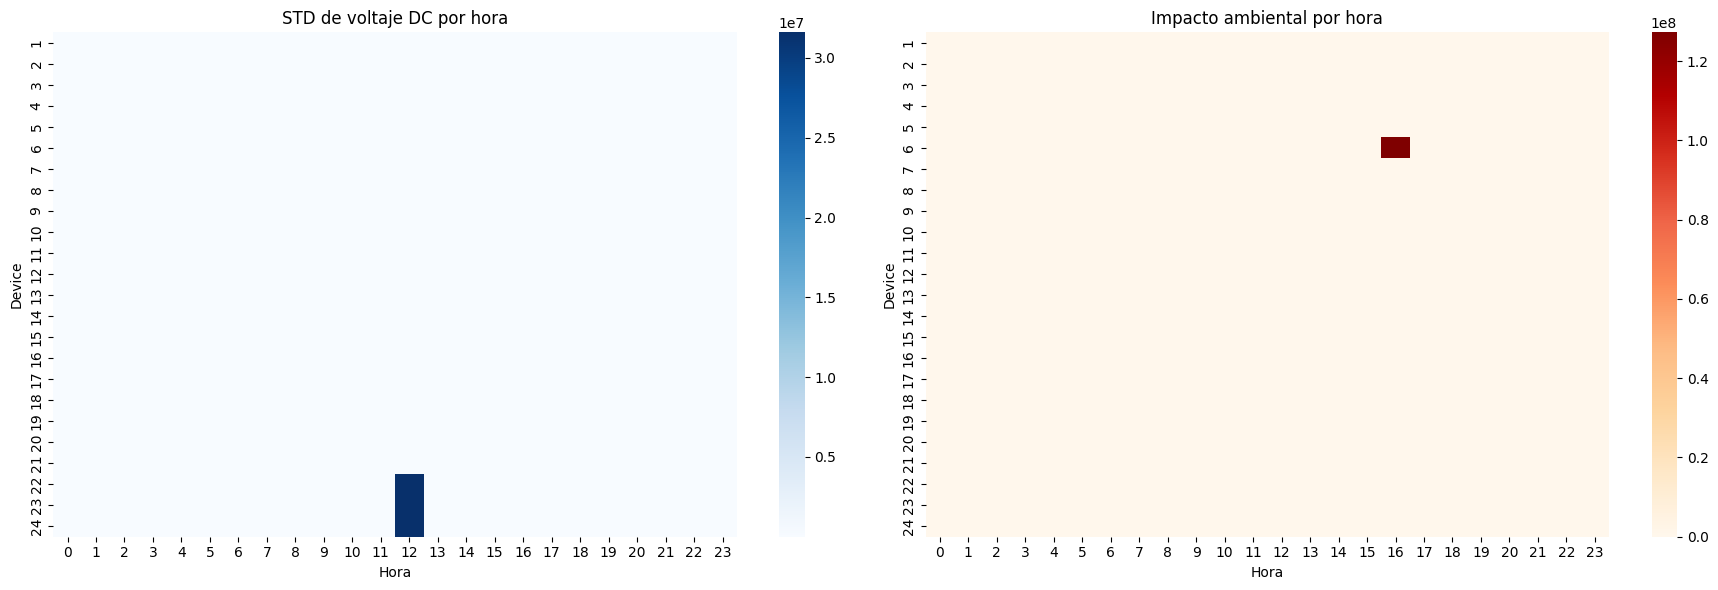

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(cube_stability['dc_voltage_std'], ax=axes[0], cmap='Blues', annot=False)
axes[0].set_title('STD de voltaje DC por hora')
axes[0].set_xlabel('Hora')
axes[0].set_ylabel('Device')

sns.heatmap(cube_stability['env_impact'], ax=axes[1], cmap='OrRd', annot=False)
axes[1].set_title('Impacto ambiental por hora')
axes[1].set_xlabel('Hora')
axes[1].set_ylabel('Device')

plt.tight_layout()
plt.show()


In [75]:
import pandas as pd
from IPython.display import display

display(cube_eff.style.background_gradient(cmap='YlOrBr'))
display(cube_stability['dc_voltage_std'].style.background_gradient(cmap='Blues'))
display(cube_stability['env_impact'].style.background_gradient(cmap='Reds'))


C:\Users\osval\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\io\formats\style.py:3811: RuntimeWarning: invalid value encountered in scalar multiply
  norm = _matplotlib.colors.Normalize(smin - (rng * low), smax + (rng * high))


6. Detección de Anomalías (3 métodos)

In [76]:
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import cdist, mahalanobis
from numpy.linalg import inv

# Variables numéricas seleccionadas
X = df_final[['conversion_efficiency', 'dc_voltage_std', 'env_impact']].dropna()
df_final = df_final.loc[X.index].copy()  # Alinear índices


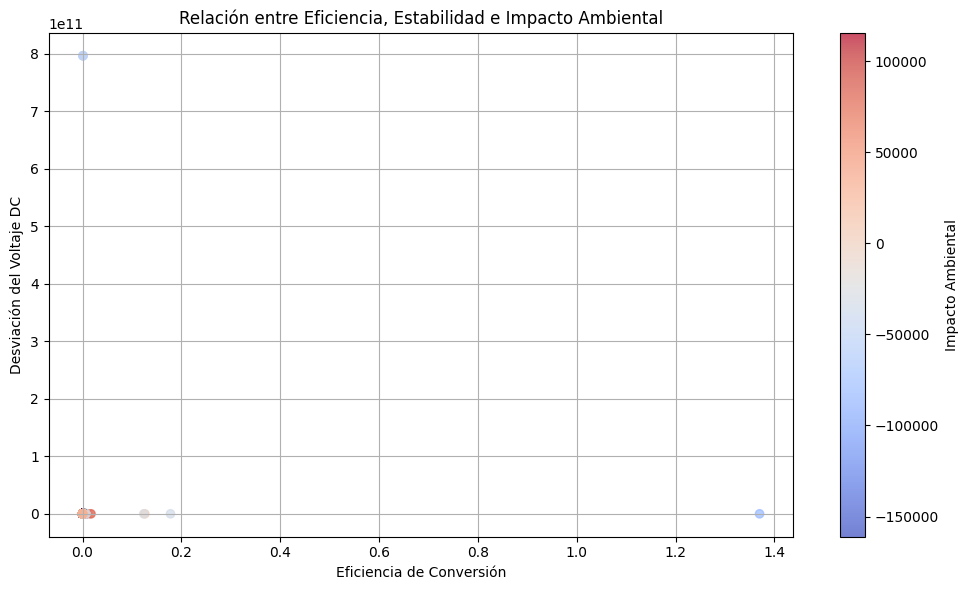

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_final['conversion_efficiency'], 
    df_final['dc_voltage_std'], 
    c=df_final['env_impact'], 
    cmap='coolwarm', 
    alpha=0.7
)
plt.colorbar(scatter, label='Impacto Ambiental')
plt.xlabel('Eficiencia de Conversión')
plt.ylabel('Desviación del Voltaje DC')
plt.title('Relación entre Eficiencia, Estabilidad e Impacto Ambiental')
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
print(df_final.columns)  # Lista todas las columnas del DataFrame


Index(['measured_on', 'device', 'ac_current_inv', 'ac_power_iinv',
       'ac_power_inv', 'ac_voltage_inv', 'dc_current_inv', 'dc_voltage_inv',
       'conversion_efficiency', 'dc_voltage_std', 'ambient_temperature',
       'env_impact', 'day', 'hour'],
      dtype='object')


In [82]:
from sklearn.ensemble import IsolationForest

# Seleccionamos las variables numéricas que usarás para detectar anomalías
features = ['env_impact', 'conversion_efficiency', 'dc_voltage_std']

# Asegúrate de que no hay valores nulos
df_model = df_final[features].dropna()

# Creamos el modelo
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_final['iso_anomaly'] = iso_forest.fit_predict(df_model)

df_final['iso_anomaly'].fillna(1, inplace=True)  


C:\Users\osval\AppData\Local\Temp\ipykernel_13156\3537587467.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['iso_anomaly'].fillna(1, inplace=True)  # opcional


C:\Users\osval\AppData\Local\Temp\ipykernel_13156\4049832002.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\osval\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


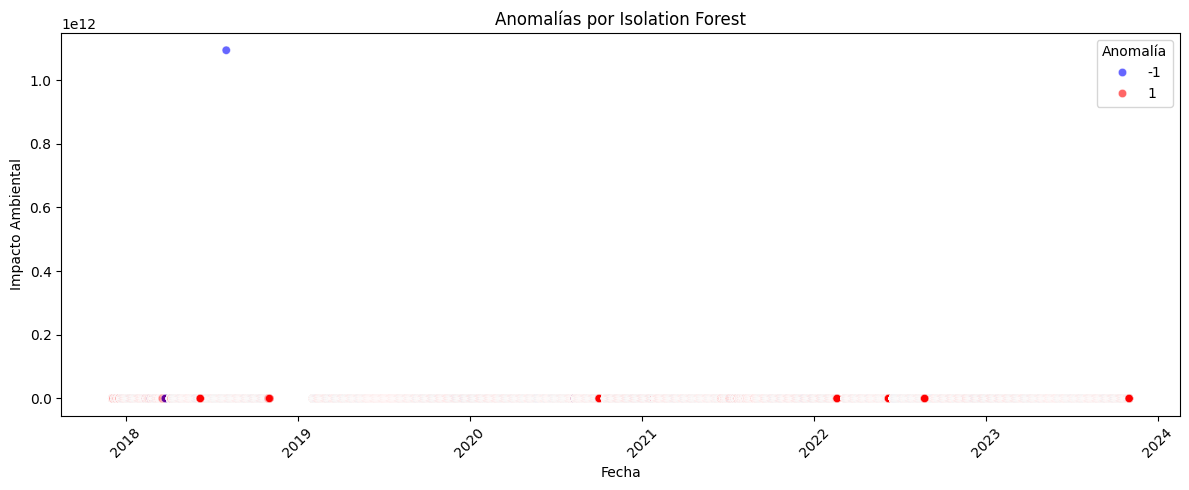

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df_final,
    x='measured_on',
    y='env_impact',
    hue='iso_anomaly',
    palette={1: 'red', -1: 'blue'},
    alpha=0.6
)
plt.title('Anomalías por Isolation Forest')
plt.xlabel('Fecha')
plt.ylabel('Impacto Ambiental')
plt.legend(title='Anomalía')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [86]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Paso 1: Definir columnas de interés
features = ['env_impact', 'conversion_efficiency', 'dc_voltage_std']

# Paso 2: Reemplazar infinitos por NaN
df_final[features] = df_final[features].replace([np.inf, -np.inf], np.nan)

# Paso 3: Eliminar filas con NaN en esas columnas
df_limpio = df_final.dropna(subset=features)

# Paso 4: Escalar
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_limpio[features])

# Paso 5: Calcular distancias euclidianas
centroid = np.mean(scaled_data, axis=0)
distances = np.linalg.norm(scaled_data - centroid, axis=1)

# Paso 6: Crear columna de anomalía (umbral del 5%)
threshold = np.percentile(distances, 95)
df_limpio['euclidean_anomaly'] = (distances > threshold).astype(int)


C:\Users\osval\AppData\Local\Temp\ipykernel_13156\4140277995.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['euclidean_anomaly'] = (distances > threshold).astype(int)


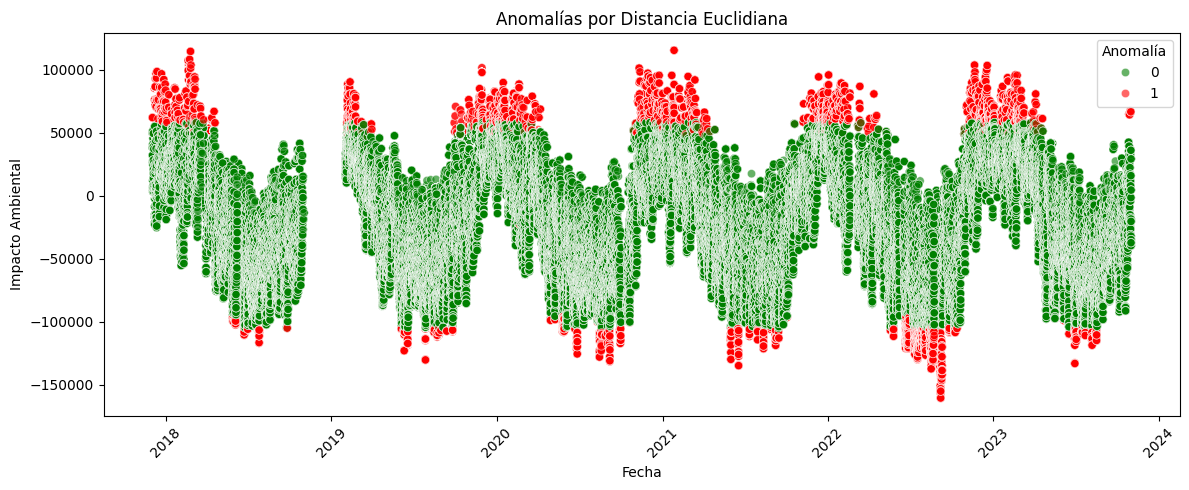

In [87]:
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df_limpio,  
    x='measured_on',
    y='env_impact',
    hue='euclidean_anomaly',
    palette={1: 'red', 0: 'green'},
    alpha=0.6
)
plt.title('Anomalías por Distancia Euclidiana')
plt.xlabel('Fecha')
plt.ylabel('Impacto Ambiental')
plt.legend(title='Anomalía')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [91]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.covariance import EmpiricalCovariance

# Selecciona variables relevantes
X = df_final[['conversion_efficiency', 'dc_voltage_std']].dropna()

# Ajustar modelo de covarianza
cov = EmpiricalCovariance().fit(X)
mahal_dist = cov.mahalanobis(X)

# Agregar al DataFrame original (solo las filas sin NaN que usaste)
df_final.loc[X.index, 'mahalanobis_dist'] = mahal_dist

# Definir umbral (e.g., percentil 95)
threshold = np.percentile(mahal_dist, 95)

# Crear columna binaria de anomalía
df_final['mahalanobis_anomaly'] = (df_final['mahalanobis_dist'] > threshold).astype(int)


C:\Users\osval\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


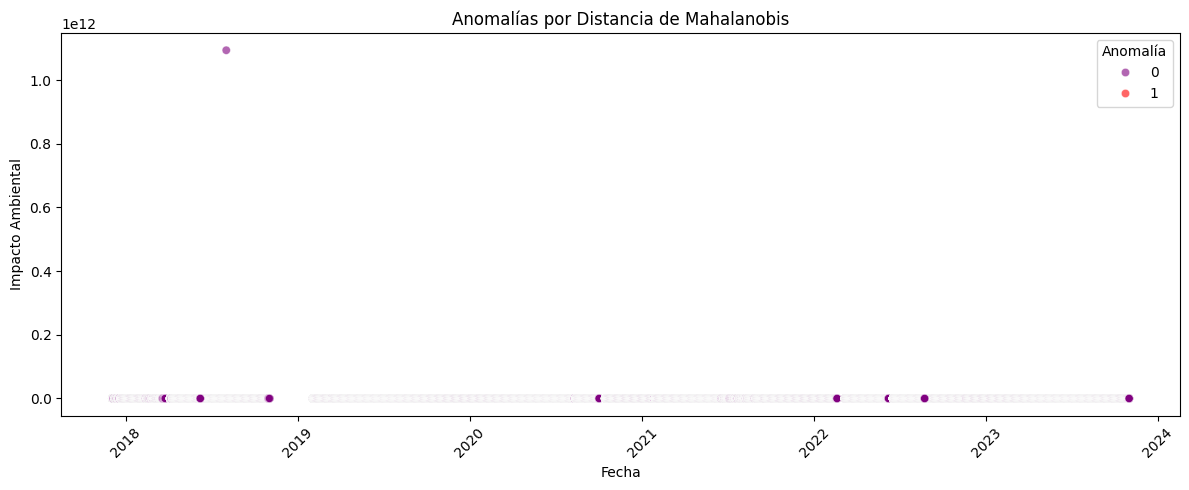

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df_final,
    x='measured_on',
    y='env_impact',
    hue='mahalanobis_anomaly',
    palette={1: 'red', 0: 'purple'},
    alpha=0.6
)
plt.title('Anomalías por Distancia de Mahalanobis')
plt.xlabel('Fecha')
plt.ylabel('Impacto Ambiental')
plt.legend(title='Anomalía')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 7. Lista de Fechas con Anomalías

In [93]:
anomaly_dates = df_final[df_final['iso_anomaly'] == -1]['measured_on'].dt.date.unique()
print(sorted(anomaly_dates))


[datetime.date(2017, 12, 2), datetime.date(2017, 12, 3), datetime.date(2017, 12, 4), datetime.date(2017, 12, 5), datetime.date(2017, 12, 6), datetime.date(2017, 12, 7), datetime.date(2017, 12, 8), datetime.date(2017, 12, 9), datetime.date(2017, 12, 10), datetime.date(2017, 12, 11), datetime.date(2017, 12, 12), datetime.date(2017, 12, 15), datetime.date(2017, 12, 16), datetime.date(2017, 12, 17), datetime.date(2017, 12, 18), datetime.date(2017, 12, 20), datetime.date(2017, 12, 21), datetime.date(2017, 12, 22), datetime.date(2017, 12, 23), datetime.date(2017, 12, 24), datetime.date(2017, 12, 25), datetime.date(2017, 12, 26), datetime.date(2017, 12, 27), datetime.date(2017, 12, 28), datetime.date(2017, 12, 29), datetime.date(2017, 12, 30), datetime.date(2017, 12, 31), datetime.date(2018, 1, 1), datetime.date(2018, 1, 2), datetime.date(2018, 1, 3), datetime.date(2018, 1, 4), datetime.date(2018, 1, 5), datetime.date(2018, 1, 6), datetime.date(2018, 1, 7), datetime.date(2018, 1, 8), datetime

In [94]:
# Contar cuántas anomalías hay por día
anomaly_summary = (
    df_final[df_final['iso_anomaly'] == -1]
    .groupby(df_final['measured_on'].dt.date)
    .size()
    .reset_index(name='anomaly_count')
    .sort_values(by='anomaly_count', ascending=False)
)

# Mostrar tabla
import pandas as pd
from IPython.display import display
display(anomaly_summary)


measured_on  anomaly_count
422   2019-05-12            437
423   2019-05-13            423
331   2019-02-10            391
332   2019-02-11            282
393   2019-04-13            274
...          ...            ...
1209  2021-09-14              1
1196  2021-09-01              1
1195  2021-08-31              1
1907  2023-09-16              1
1886  2023-08-24              1

[1953 rows x 2 columns]

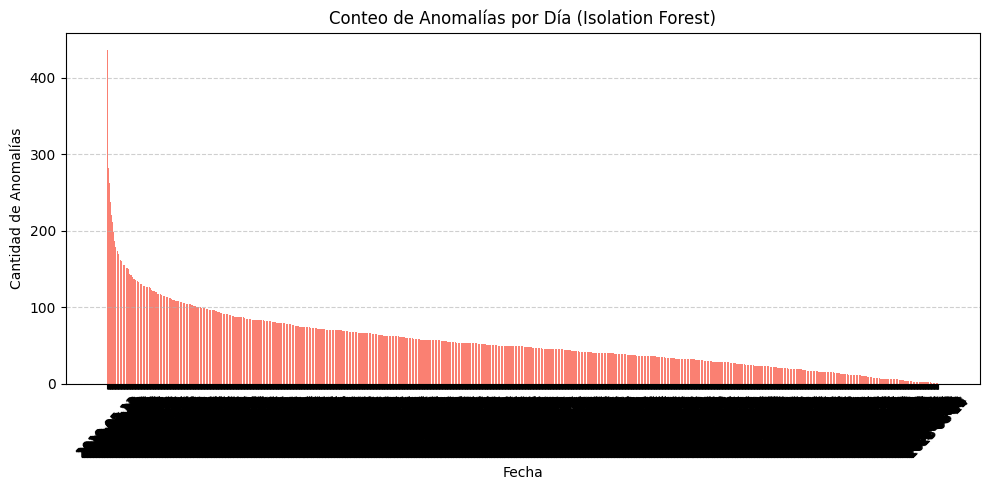

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(anomaly_summary['measured_on'].astype(str), anomaly_summary['anomaly_count'], color='salmon')
plt.title('Conteo de Anomalías por Día (Isolation Forest)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Anomalías')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


8. Predicción con Prophet

C:\Users\osval\AppData\Local\Temp\ipykernel_13156\3521094758.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_final.groupby([pd.Grouper(key='measured_on', freq='H'), 'device']).mean(numeric_only=True).reset_index()
20:58:49 - cmdstanpy - INFO - Chain [1] start processing
20:58:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\osval\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


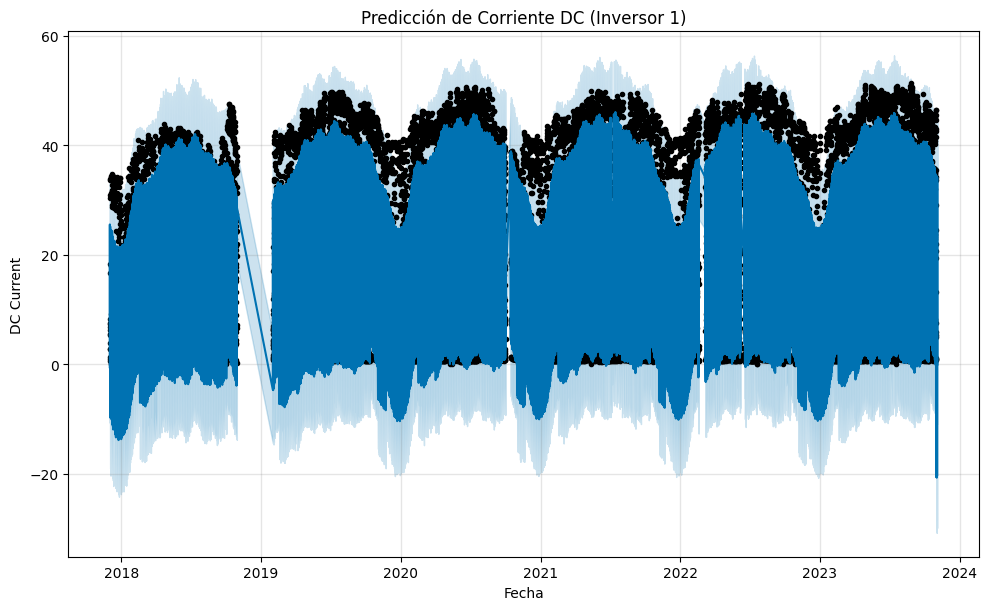

In [96]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Agrupación horaria y cálculo del promedio por inversor
df_hourly = df_final.groupby([pd.Grouper(key='measured_on', freq='H'), 'device']).mean(numeric_only=True).reset_index()

# Filtrar por un inversor específico (ajusta si el valor no es 1, por ejemplo usa '01' si es string)
device1 = df_hourly[df_hourly['device'] == 1]

# Preparar los datos para Prophet
prophet_df = device1[['measured_on', 'dc_current_inv']] \
    .rename(columns={'measured_on': 'ds', 'dc_current_inv': 'y'}) \
    .dropna()

# Instanciar y entrenar el modelo
model = Prophet()
model.fit(prophet_df)

# Crear fechas futuras para predicción
future = model.make_future_dataframe(periods=72, freq='H')
forecast = model.predict(future)

# Graficar la predicción
model.plot(forecast)
plt.title('Predicción de Corriente DC (Inversor 1)')
plt.xlabel('Fecha')
plt.ylabel('DC Current')
plt.show()


In [97]:
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import cdist, mahalanobis
from numpy.linalg import inv
import numpy as np

# === Datos ===
features = ['conversion_efficiency', 'dc_voltage_std', 'env_impact']
X = df_final[features].dropna()
df_filtered = df_final.loc[X.index].copy()

# === Isolation Forest ===
iso_model = IsolationForest(contamination=0.05, random_state=42)
df_filtered['iso_anomaly'] = iso_model.fit_predict(X)

# === Euclidiana ===
mean_vec = X.mean().values.reshape(1, -1)
eu_dist = cdist(X, mean_vec)
df_filtered['euclidean_anomaly'] = (eu_dist.flatten() > np.percentile(eu_dist, 95)).astype(int)

# === Mahalanobis ===
cov = np.cov(X.values, rowvar=False)
inv_cov = inv(cov)
mean_vals = X.mean().values
maha = X.apply(lambda row: mahalanobis(row, mean_vals, inv_cov), axis=1)
df_filtered['mahalanobis_anomaly'] = (maha > np.percentile(maha, 95)).astype(int)


In [98]:
# ¿Qué porcentaje coincide entre métodos?
consistency = (
    (df_filtered['iso_anomaly'] == -1).astype(int) +
    df_filtered['euclidean_anomaly'] +
    df_filtered['mahalanobis_anomaly']
)

df_filtered['consensus'] = consistency  # 0 a 3


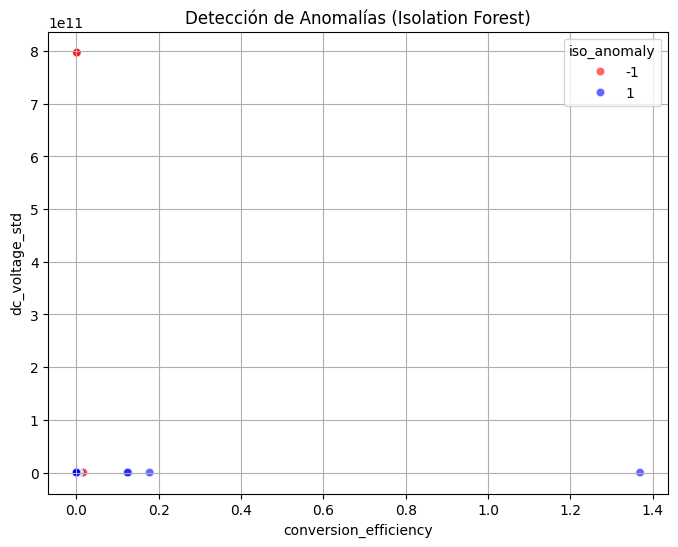

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_filtered,
    x='conversion_efficiency',
    y='dc_voltage_std',
    hue='iso_anomaly',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title('Detección de Anomalías (Isolation Forest)')
plt.grid(True)
plt.show()


<Axes: xlabel='date'>

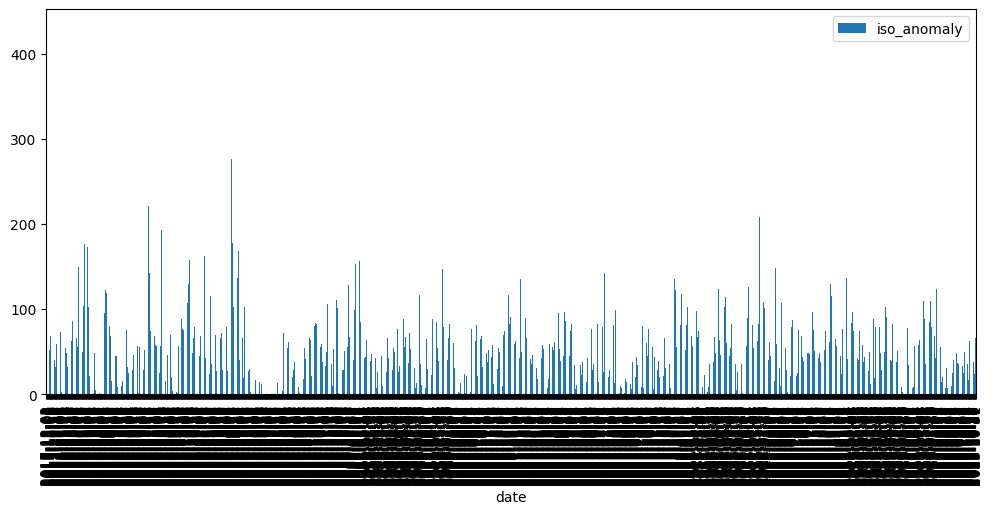

In [100]:
df_filtered['date'] = df_filtered['measured_on'].dt.date
df_filtered.groupby('date')[['iso_anomaly']].apply(lambda x: (x==-1).sum()).plot(kind='bar', figsize=(12,5))


In [102]:
# Convertimos las anomalías a 1 para facilitar conteo
df_filtered['iso_anomaly_flag'] = (df_filtered['iso_anomaly'] == -1).astype(int)

# Agrupamos por dispositivo
anomaly_summary = df_filtered.groupby('device').agg({
    'iso_anomaly_flag': 'sum',
    'euclidean_anomaly': 'sum',
    'mahalanobis_anomaly': 'sum'
}).rename(columns={
    'iso_anomaly_flag': 'Isolation Forest',
    'euclidean_anomaly': 'Distancia Euclidiana',
    'mahalanobis_anomaly': 'Mahalanobis'
})

# Total de anomalías
anomaly_summary['Total Anomalías'] = anomaly_summary.sum(axis=1)

# Mostramos la tabla ordenada
anomaly_summary = anomaly_summary.sort_values('Total Anomalías', ascending=False)
display(anomaly_summary.style.background_gradient(cmap='Reds'))


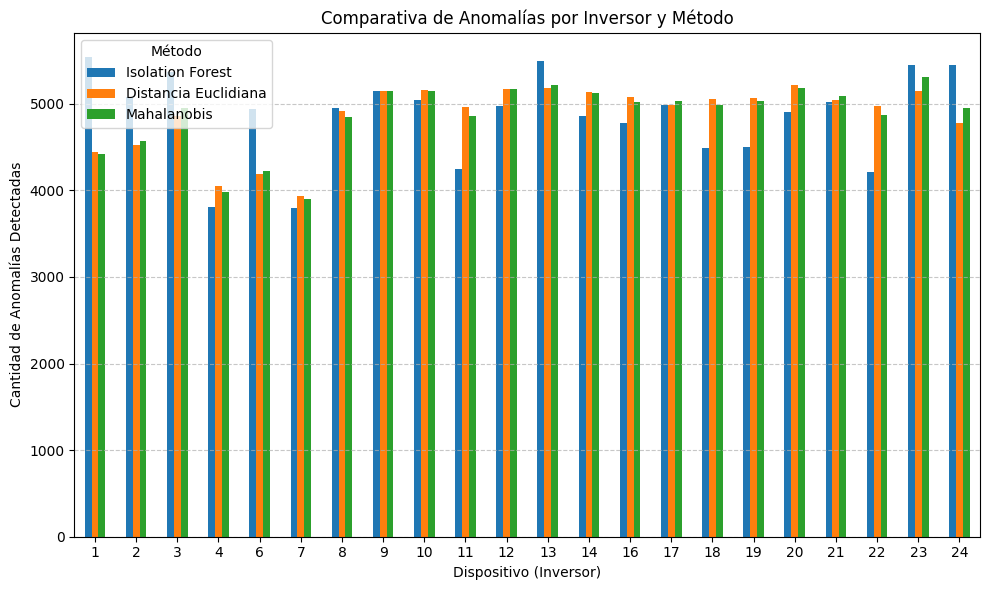

In [ ]:
import matplotlib.pyplot as plt

# Si no lo has hecho ya:
df_filtered['iso_anomaly_flag'] = (df_filtered['iso_anomaly'] == -1).astype(int)

# Agrupar por inversor
anomaly_summary = df_filtered.groupby('device').agg({
    'iso_anomaly_flag': 'sum',
    'euclidean_anomaly': 'sum',
    'mahalanobis_anomaly': 'sum'
}).rename(columns={
    'iso_anomaly_flag': 'Isolation Forest',
    'euclidean_anomaly': 'Distancia Euclidiana',
    'mahalanobis_anomaly': 'Mahalanobis'
})

# Plot
anomaly_summary.plot(kind='bar', figsize=(10, 6))

plt.title('Comparativa de Anomalías por Inversor y Método')
plt.xlabel('Dispositivo (Inversor)')
plt.ylabel('Cantidad de Anomalías Detectadas')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método')
plt.tight_layout()
plt.show()
    